## K-means clustering-inspired segmentation

In [147]:
import matplotlib.pyplot as plt
from skimage.future import graph
from skimage import data, segmentation, color, filters, io
import numpy as np

In [4]:
im = data.coffee()
im_g = color.rgb2gray(im)

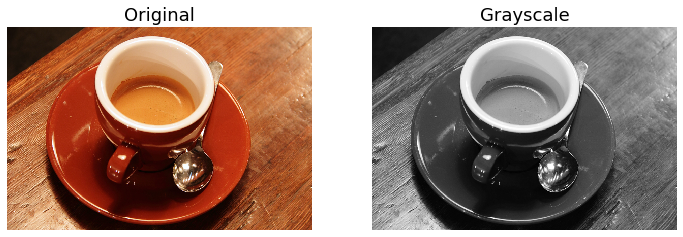

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(12,7))
titles = ['Original', 'Grayscale']

for ax, title in zip(axes, titles):
    ax.axis('off')
    ax.set_title(title, fontsize=18)


axes[0].imshow(im)
axes[1].imshow(im_g, cmap='gray')

In this example, we're going to take advantage of a machine learning algorithm known as [k means clustering](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html). K-means clustering is an unsupervised machine learning method, meaning there is no target output we're trying to force on our model. K-means clustering tries to look for similarities in your data based on whatever features you provide. In case of colored images, our features are the R, G, and B components, as well as the spatial coordinates of the pixels. We are going to try to look for clusters of similarly colored pixels that are preferably close to each other to break our image into regions.

For clarity, let's try a non-image example, so you can get an idea of what is going on underneath the hood

In [158]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

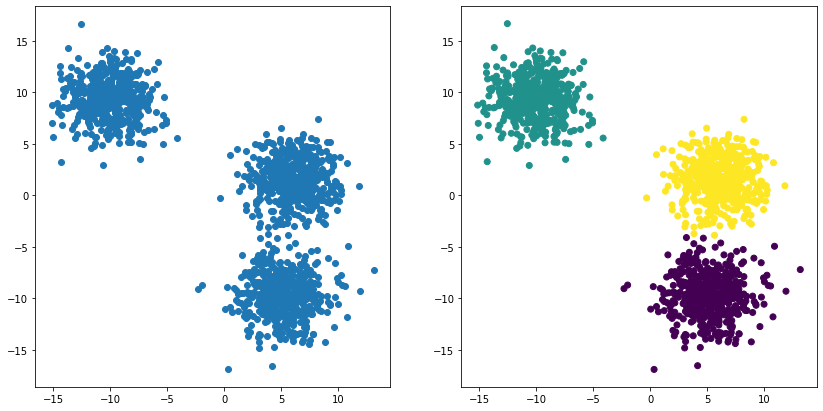

In [165]:
# Define a dataset
n_samples = 1500
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                centers=3,
                                cluster_std=[2., 2., 2.])

y_pred = KMeans(n_clusters=3).fit_predict(X_varied)

fig, axes = plt.subplots(ncols=2, figsize=(14,7))

# for ax in axes:
#     ax.axis('off')
    
axes[0].scatter(X_varied[:, 0], X_varied[:, 1])
axes[1].scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)

In this first step, we will find the regions via clustering, and then take the "average" shade in each region to reconstruct a "simplified" version of the image. By itself, this method has some pretty results using the coffee cup. Try changing the number of segments in the K-means clustering algorithm to see how it affects the image.

In [47]:
labels = segmentation.slic(im, compactness=30, n_segments=400)
im_label = color.label2rgb(labels, image=im_g)
im_out = color.label2rgb(labels, im, kind='avg')

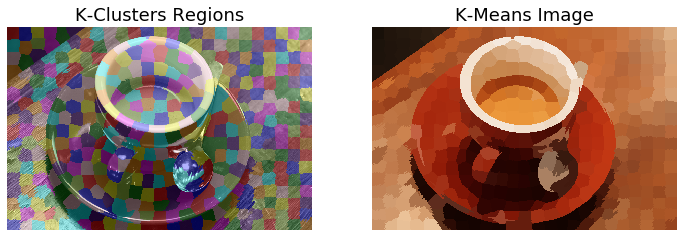

In [64]:
fig, axes = plt.subplots(ncols=2, figsize=(12,7))
titles = ['K-Clusters Regions', 'K-Means Image']

for ax, title in zip(axes, titles):
    ax.axis('off')
    ax.set_title(title, fontsize=18)
    
axes[0].imshow(im_label, cmap='prism')
axes[1].imshow(im_out)
#axes[1].imshow(edges_rgb)

We are going to further improve the image by using something called a Region Adjacency Graph (RAG). Each region in the image is represented as a node on a graph, visualized as the centroid of the region (see graph image below). There is an edge between every pair of adjacent regions.

The weight between each node is a measure of how similar they are and can be defined in a variety of ways. The more similar the regions, the less weight between them. 

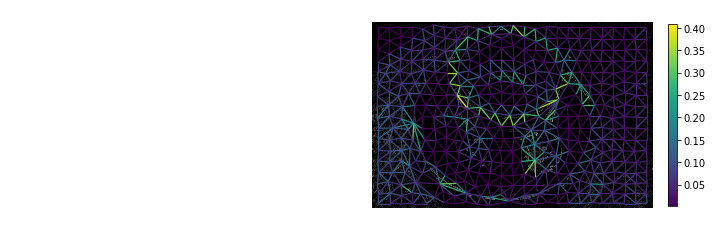

In [109]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
#titles = ['K-Clusters Regions', 'Sobel Edges']

for ax, title in zip(axes, titles):
    ax.axis('off')
    #ax.set_title(title, fontsize=18)

edges = filters.sobel(im_g)
edges_rgb = color.gray2rgb(edges)
g = graph.rag_boundary(labels, edges)
lc = graph.show_rag(labels, g, edges_rgb, img_cmap=None, edge_cmap='viridis', edge_width=1.2, ax=axes[1])

fig.colorbar(lc, fraction=0.03)
#axes[0].imshow(im_label, cmap='prism')
#axes[1].imshow(im_out)

In [72]:
def merge_boundary(graph, src, dst):
    """Call back called before merging two nodes.
    
    In this case, there is no computation.
    """
    pass


def weight_boundary(graph, src, dst, n):
    """
    Handle merging of nodes of a region boundary adjacency graph.
    
    This function computes the "weight" and the "count" attributes
    of the edge between "n" and the node formed after merging "src"
    and "dst".
    
    Parameters
    ----------
    graph : RAG
        The graph under consideration
    src, dst : int
        The vertices in "graph" to be merged
    n : int
        A neighbor of "src" or "dst" or both.
        
    Returns
    -------
    data : dict
        A dictionary with the "weight" and "count" attributes
        to be assigned for the merged node.
    """
    
    default = {'weight': 0.0, "count": 0}
    
    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']
    
    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']
    
    count = count_src + count_dst
    
    return {
        'count': count,
        'weight': (count_src*weight_src + count_dst*weight_dst)/count
    }
    
    

In [126]:
label2 = graph.merge_hierarchical(labels, g, thresh=0.045, rag_copy=False, in_place_merge=True,
                                  merge_func=merge_boundary, weight_func=weight_boundary)

im_label2 = color.label2rgb(label2, image=im_g)
im_out2 = color.label2rgb(label2, im, kind='avg')

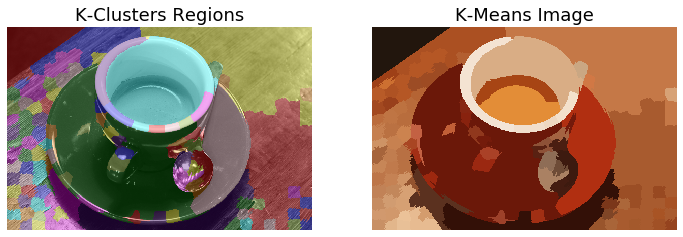

In [127]:
fig, axes = plt.subplots(ncols=2, figsize=(12,7))
titles = ['K-Clusters Regions', 'K-Means Image']

for ax, title in zip(axes, titles):
    ax.axis('off')
    ax.set_title(title, fontsize=18)
    
axes[0].imshow(im_label2, cmap='prism')
axes[1].imshow(im_out2)
#axes[1].imshow(edges_rgb)

An alternate approach to do something similar:

In [138]:
g = graph.rag_mean_color(im, labels)
labels3 = graph.cut_threshold(labels, g, 14)
im_label3 = color.label2rgb(labels3, image=im_g)
im_out3 = color.label2rgb(labels3, im, kind='avg')

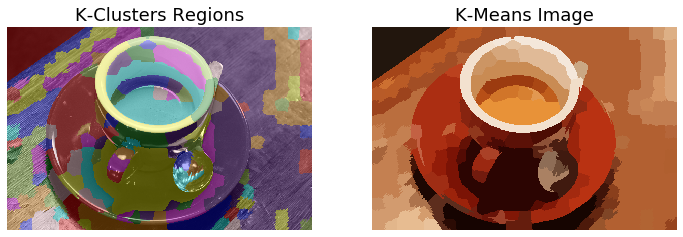

In [139]:
fig, axes = plt.subplots(ncols=2, figsize=(12,7))
titles = ['K-Clusters Regions', 'K-Means Image']

for ax, title in zip(axes, titles):
    ax.axis('off')
    ax.set_title(title, fontsize=18)
    
axes[0].imshow(im_label3, cmap='prism')
axes[1].imshow(im_out3)

Yet another method that takes into account the mean color before merging.

In [148]:
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                     graph.nodes[dst]['pixel count'])

In [156]:
g = graph.rag_mean_color(im, labels)

labels4 = graph.merge_hierarchical(labels, g, thresh=60, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

im_label4 = color.label2rgb(labels4, image=im_g)
im_out4 = color.label2rgb(labels4, im, kind='avg')
#out = segmentation.mark_boundaries(out, labels4, (0, 0, 0))

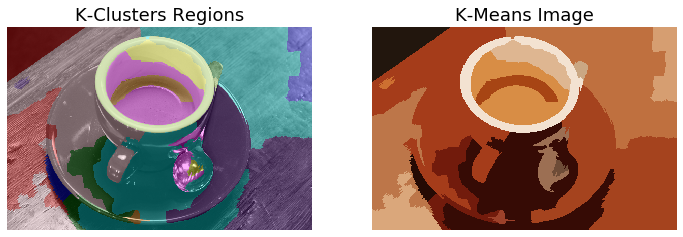

In [157]:
fig, axes = plt.subplots(ncols=2, figsize=(12,7))
titles = ['K-Clusters Regions', 'K-Means Image']

for ax, title in zip(axes, titles):
    ax.axis('off')
    ax.set_title(title, fontsize=18)
    
axes[0].imshow(im_label4, cmap='prism')
axes[1].imshow(im_out4)

Great source on the explanation:
    
https://vcansimplify.wordpress.com/2014/07/06/scikit-image-rag-introduction/